In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Loading and Understanding the Data

In [2]:
df_classes = pd.read_csv('elliptic_bitcoin_dataset/elliptic_txs_classes.csv')
df_classes['class'] = df_classes['class'].replace('unknown', -1)
df_classes['class'] = pd.to_numeric(df_classes['class'])

In [3]:
df_edges = pd.read_csv('elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')


In [4]:
df_features = pd.read_csv('elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)

In [5]:
df_edges.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [6]:
df_classes.head()

,txId,class
0,230425980,-1
1,5530458,-1
2,232022460,-1
3,232438397,2
4,230460314,-1


In [7]:
# Merge classes and features
df_merge = pd.merge(df_classes, df_features, left_on='txId', right_on=0)

In [8]:
df_merge.head()

,txId,class,0,1,2,3,4,5,6,7,...,157,158,159,160,161,162,163,164,165,166
0,230425980,-1,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,-1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,-1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,-1,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [9]:
df_ct = df_merge[[1,'class']]
c0 = df_ct[df_ct['class']==-1]
c1 = df_ct[df_ct['class']==1]
c2 = df_ct[df_ct['class']==2]

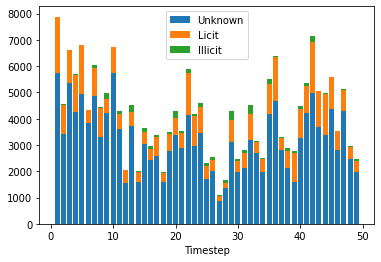

In [54]:
c0_count = c0.value_counts().sort_index(axis=0)
c1_count = c1.value_counts().sort_index(axis=0)
c2_count = c2.value_counts().sort_index(axis=0)

plt.bar([i for i in range(1,50)], c0_count)
plt.bar([i for i in range(1,50)], c2_count, bottom=c0_count)
plt.bar([i for i in range(1,50)], c1_count, bottom=c0_count.to_numpy()+c2_count.to_numpy())
plt.legend(["Unknown", "Licit", "Illicit"])
plt.xlabel("Timestep")
plt.savefig("time_count.png")

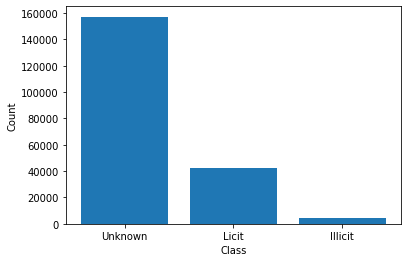

In [53]:
classes = df_classes['class'].value_counts()
plt.bar(['Unknown', 'Licit', 'Illicit'],classes)
plt.xlabel("Class")
plt.ylabel("Count")
# 0 = Unknown, 2 = Licit, 1 = Illicit
plt.savefig("actual_class.png")

In [12]:
# Separate unknown and known instances
df_class_k = df_classes[df_classes['class'] != -1]
df_class_k["txId"].head()

3     232438397
9     232029206
10    232344069
11     27553029
16      3881097
Name: txId, dtype: int64

In [13]:
# Retrieve features for only known instances
df_features_new = df_features[0].isin(df_class_k["txId"])

In [14]:
df_features_new = df_features[df_features_new]

# Classifiers: SVM, Random Forest, and Adaboost

In [15]:
# Train and test set of known instances
train_df_c, test_df_c = train_test_split(df_class_k, test_size=0.2)


In [16]:
f_bool = df_features[0].isin(train_df_c["txId"])
train_df_f = df_features[f_bool]

f_bool = df_features[0].isin(test_df_c["txId"])
test_df_f = df_features[f_bool]

In [17]:
# Check the sizes align
print(train_df_f.shape)
print(train_df_c.shape)

print(test_df_f.shape)
print(test_df_c.shape)


(37251, 167)
(37251, 2)
(9313, 167)
(9313, 2)


In [18]:
train_df_c_ind = train_df_c.set_index('txId')
train_df_f_ind = train_df_f.set_index(0)

In [19]:
test_df_c_ind = test_df_c.set_index('txId')
test_df_f_ind = test_df_f.set_index(0)

In [20]:
# Joins to get classes and features aligned
a1, a2 = train_df_f_ind.align(train_df_c_ind, join='left', axis=0)[:10]

In [21]:
a3, a4 = test_df_f_ind.align(test_df_c_ind, join='left', axis=0)

In [37]:
# Accuracy and F1 scores for performance metrics

from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import f1_score

acc = accuracy(y_pred, a4['class'].tolist())
f1 = f1_score(a4['class'].tolist(), y_pred, average='weighted')

In [29]:
from sklearn import svm
clf = svm.SVC()
clf.fit(a1, a2['class'])

SVC()

In [33]:
print("SVM")
print(acc)
print(f1)

SVM
0.959304198432299
0.9571906121272075


In [31]:
y_pred = clf.predict(a3)

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

for i in range(8,9):
    clf = RandomForestClassifier(max_depth=i, random_state=0)
    clf.fit(a1, a2['class'])
    y_pred = clf.predict(a3)
    acc = accuracy(y_pred, a4['class'].tolist())
    print(i, acc)

8 0.9806721786749705


In [28]:
print("Random Forest")
print(acc)
print(f1)

Random Forest
0.9623107484161925
0.958512725968319


In [36]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=50, random_state=0)
clf.fit(a1, a2['class'])

AdaBoostClassifier(random_state=0)

In [38]:
print("Adaboost")
print(acc)
print(f1)

Adaboost
0.9873295393535918
0.9869632999468915


In [26]:
y_pred = clf.predict(a3)

In [43]:
pred_df_c = df_classes.dropna()
pred_df_c = pred_df_c[pred_df_c['class'] == -1]
pred_df_f_bool = df_features[0].isin(pred_df_c["txId"])
pred_df_f = df_features[pred_df_f_bool]
pred_df_f = pred_df_f.set_index(0)


In [44]:
# Apply classifier model to unlabelled data

unknown_pred = clf.predict(pred_df_f)

In [48]:
ones = np.count_nonzero(unknown_pred == 1)
twos = np.count_nonzero(unknown_pred == 2)

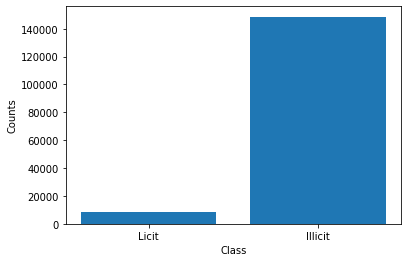

In [52]:
plt.bar(["Licit", "Illicit"], [ones, twos])
plt.ylabel("Counts")
plt.xlabel("Class")
plt.savefig("predicted_class.png")

# Graphs and Deepwalk

In [83]:
import networkx as nx
import deepwalk

# Create graph using edge list and networkx

G = nx.Graph()
G = nx.from_pandas_edgelist(df_edges, 'txId1', 'txId2')


In [81]:
df_edges

,txId1,txId2
0,0,1
1,2,3
2,4,5
3,6,7
4,8,9
...,...,...
234350,203602,201430
234351,203603,203099
234352,201921,202042
234353,201480,201368


In [8]:
df_edges.shape

(234355, 2)

In [9]:
# Save graph for use in deepwalk

nx.write_edgelist(G, 'elliptic_bitcoin_dataset/edge_list.edge')

In [1]:
# Deepwalk (using small num walks and walk length due to excessive time on large graph)

!deepwalk --format edgelist --input elliptic_bitcoin_dataset/edge_list.edge --number-walks 10 --representation-size 64 --walk-length 15 --window-size 6 --output edges.embeddings

Number of nodes: 203769
Number of walks: 2037690
Data size (walks*length): 30565350
Walking...
Training...


In [ ]:
nx.draw(G)

In [4]:
# Load deepwalk embeddings

embed = np.loadtxt('elliptic_bitcoin_dataset/edges.embedding', skiprows = 1)

In [8]:
df_classes.shape

(203769, 2)

In [28]:
from karateclub import DeepWalk

In [84]:
model = DeepWalk(walk_number=2, walk_length=20, dimensions=32, workers=4)
model.fit(G)
embeddings = model.get_embedding()

In [85]:
embeddings.shape

(203769, 32)

In [50]:
df_c = df_classes.copy(deep=True)
df_edges.join(df_c, on="txId1")

,txId1,txId2,txId,class
0,230425980,5530458,NaN,NaN
1,232022460,232438397,NaN,NaN
2,230460314,230459870,NaN,NaN
3,230333930,230595899,NaN,NaN
4,232013274,232029206,NaN,NaN
...,...,...,...,...
234350,158365409,157930723,NaN,NaN
234351,188708874,188708879,NaN,NaN
234352,157659064,157659046,NaN,NaN
234353,87414554,106877725,NaN,NaN


In [61]:
keys = df_c.to_dict()['txId']
res = dict((v,k) for k,v in keys.items())

In [66]:
df_edges['txId1'] = df_edges['txId1'].apply(lambda x: res[x])
df_edges['txId2'] = df_edges['txId2'].apply(lambda x: res[x])


In [ ]:
dfc = df_classes['class'].values.astype(int)

In [ ]:
from sklearn.semi_supervised import LabelSpreading

model = LabelSpreading()
model.fit(embeddings, dfc)